# Calgary Traffic Analysis

In [1]:
import csv
import re
import folium
from folium.features import DivIcon
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_rows',10)
import numpy as np
import seaborn as sns

import city_boundary as cb
import weather_functions as wf

In [2]:
# parsing City_Boundary_layer.csv to retrieve a list of boundary coordinates
boundary_coordinates = cb.get_boundary_coordinates('City_Boundary_layer.csv')
coordinate_list = cb.get_coordinate_list(boundary_coordinates)

In [3]:
# finding the north, south, east, and west most coordinates from boundary coordinate list
north = max(coordinate_list[0])
south = min(coordinate_list[0])
east = max(coordinate_list[1])
west = min(coordinate_list[1])

# assigning the four boundary corner coordinates
nw = [north, west]
ne = [north, east]
se = [south, east]
sw = [south, west]

# dataframe containing coordinate locations of the four boundary corners
boundary_corners_df = pd.DataFrame([nw,ne,se,sw],\
                                   index=['NW','NE','SE','SW'],\
                                   columns=['Latitude','Longitude'])

boundary_corners_df

,Latitude,Longitude
NW,51.212425,-114.315796
NE,51.212425,-113.859905
SE,50.842822,-113.859905
SW,50.842822,-114.315796


In [4]:
m = folium.Map(location=[51.0447, -114.0719], zoom_start=10)

# boundary lines
cb.draw_boundary_lines(nw,ne,sw,se,m)

m

In [5]:
# gathering points to plot ployline grid
top_points = cb.get_plot_points(ne,nw)
right_points = cb.get_plot_points(se,ne)
bottom_points = cb.get_plot_points(se,sw)
left_points = cb.get_plot_points(sw,nw)

# drawing grid on folium map
cb.draw_grid_lines(top_points, bottom_points, left_points, right_points, m)

m

In [6]:
# computing cell boundaries and assigning cell locations
cells = cb.get_cell_boundaries(top_points, left_points)
cb.draw_cell_number(cells, m)

m

In [7]:
# dataframe containing cell boundaries
cells_df = pd.DataFrame(cells,\
                        index=np.arange(1, len(cells)+1),\
                        columns=['North Boundary','East Boundary','South Boundary','West Boundary'])

cells_df

,North Boundary,East Boundary,South Boundary,West Boundary
1,51.212425,-114.270207,51.175465,-114.315796
2,51.212425,-114.224618,51.175465,-114.270207
3,51.212425,-114.179029,51.175465,-114.224618
4,51.212425,-114.133440,51.175465,-114.179029
5,51.212425,-114.087851,51.175465,-114.133440
...,...,...,...,...
96,50.879782,-114.042261,50.842822,-114.087851
97,50.879782,-113.996672,50.842822,-114.042261
98,50.879782,-113.951083,50.842822,-113.996672
99,50.879782,-113.905494,50.842822,-113.951083


# Weather Data Analysis

In [8]:
# url string with variables station, year, month, tf
url_template = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station}&Year={year}&Month={month}&Day=14&timeframe={tf}&submit=Download+Data"

# contains 12 monthly weather dataframes from 2018
weather_data_list = []

for month in range(12):
    # replacing variables in string with values from 2018, note tf=1 refers to hourly data
    url = url_template.format(station=50430, year=2018, month=(month+1), tf=1)
    
    # get the current months weather data and clean up degree symbol from column name
    monthly_weather_data = pd.read_csv(url, index_col='Date/Time',parse_dates=True)
    monthly_weather_data.columns = [col.replace('\xb0','') for col in monthly_weather_data.columns]
    
    weather_data_list.append(monthly_weather_data)
    
# combines the weather data from all 12 months in 2018 into a single dataframe
weather_data = pd.concat(weather_data_list)

weather_data

,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Time,Temp (C),Temp Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
Date/Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,1,1,00:00,-28.1,NaN,...,NaN,24.1,NaN,89.94,NaN,NaN,NaN,-29.0,NaN,NaN
2018-01-01 01:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,1,1,01:00,-28.6,NaN,...,NaN,24.1,NaN,89.95,NaN,NaN,NaN,-30.0,NaN,NaN
2018-01-01 02:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,1,1,02:00,-29.1,NaN,...,NaN,24.1,NaN,89.95,NaN,NaN,NaN,-32.0,NaN,Mainly Clear
2018-01-01 03:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,1,1,03:00,-30.0,NaN,...,NaN,24.1,NaN,89.93,NaN,NaN,NaN,-32.0,NaN,NaN
2018-01-01 04:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,1,1,04:00,-27.6,NaN,...,NaN,24.1,NaN,89.92,NaN,NaN,NaN,-31.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,12,31,19:00,-12.8,NaN,...,NaN,24.1,NaN,89.31,NaN,NaN,NaN,-19.0,NaN,NaN
2018-12-31 20:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,12,31,20:00,-12.2,NaN,...,NaN,24.1,NaN,89.25,NaN,NaN,NaN,-17.0,NaN,Mainly Clear
2018-12-31 21:00:00,-114.01,51.12,CALGARY INTL A,3031092,2018,12,31,21:00,-11.7,NaN,...,NaN,24.1,NaN,89.15,NaN,NaN,NaN,-18.0,NaN,NaN


In [9]:
# finds rows where Temp (C) is NaN
#weather_data[weather_data['Temp (C)'].isnull()]

# finds rows where Visibility (km) is Nan
#weather_data[weather_data['Visibility (km)'].isnull()]

# clean up weather data where temperature or visibility is NaN
weather_data = weather_data.dropna(subset=['Temp (C)', 'Visibility (km)'])

In [10]:
# statistics for temperature and visibility weather data
weather_data_isolated = weather_data.drop(weather_data.columns.difference(['Temp (C)','Visibility (km)']), 1)
weather_data_isolated.describe()

,Temp (C),Visibility (km)
count,8746.000000,8746.000000
mean,4.505934,29.835296
std,11.703444,20.697898
min,-30.000000,0.000000
25%,-3.500000,16.100000
50%,4.200000,24.100000
75%,13.500000,48.300000
max,36.400000,80.500000


In [11]:
# resample the hourly weather data to get a daily report
daily_weather_data = weather_data.resample('D').mean()
daily_weather_data.drop(daily_weather_data.columns.difference(['Temp (C)','Visibility (km)']), 1, inplace=True)
daily_weather_data.describe()

,Temp (C),Visibility (km)
count,365.000000,365.000000
mean,4.514982,29.843530
std,11.049719,14.312455
min,-25.233333,1.758333
25%,-3.520833,17.033333
50%,3.825000,33.966667
75%,14.191304,41.229167
max,27.170833,53.995833


In [12]:
daily_weather_data

,Temp (C),Visibility (km)
Date/Time,,
2018-01-01,-16.683333,42.570833
2018-01-02,-3.787500,40.891667
2018-01-03,-2.391667,39.212500
2018-01-04,-5.016667,40.891667
2018-01-05,-0.345833,40.891667
...,...,...
2018-12-27,-7.225000,12.650000
2018-12-28,-4.633333,40.891667
2018-12-29,1.600000,38.475000


In [13]:
# read traffic incident data
traffic_incident_df = pd.read_csv('Traffic_Incidents.csv',parse_dates=True)

traffic_incident_df['START_DT'] = pd.to_datetime(traffic_incident_df['START_DT'])
traffic_incident_df['MODIFIED_DT'] = pd.to_datetime(traffic_incident_df['MODIFIED_DT'])

# Weather Analysis of Calgary Area

In [14]:
# retrieves the number of incidents per day in Calgary
incidents_per_day_df = traffic_incident_df.groupby(pd.to_datetime(traffic_incident_df.START_DT).dt.date).agg({
    'Count': 'sum'
}).filter(like='2018', axis=0).sort_index()

#incidents_per_day_df

In [15]:
weather_merged_df = pd.merge(daily_weather_data,incidents_per_day_df,left_index=True,right_index=True,sort=True)
weather_merged_df

,Temp (C),Visibility (km),Count
Date/Time,,,
2018-01-01,-16.683333,42.570833,12
2018-01-02,-3.787500,40.891667,30
2018-01-03,-2.391667,39.212500,26
2018-01-04,-5.016667,40.891667,22
2018-01-05,-0.345833,40.891667,20
...,...,...,...
2018-12-27,-7.225000,12.650000,21
2018-12-28,-4.633333,40.891667,10
2018-12-29,1.600000,38.475000,4


In [16]:
weather_merged_df.describe()

,Temp (C),Visibility (km),Count
count,365.000000,365.000000,365.000000
mean,4.514982,29.843530,17.991781
std,11.049719,14.312455,8.652475
min,-25.233333,1.758333,1.000000
25%,-3.520833,17.033333,12.000000
50%,3.825000,33.966667,17.000000
75%,14.191304,41.229167,22.000000
max,27.170833,53.995833,57.000000


Text(0, 0.5, 'Incident Count')

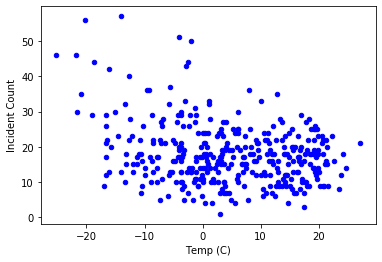

In [17]:
weather_merged_df.plot(kind='scatter',x='Temp (C)',y='Count', color='blue')
plt.ylabel('Incident Count')

Text(0, 0.5, 'Incident Count')

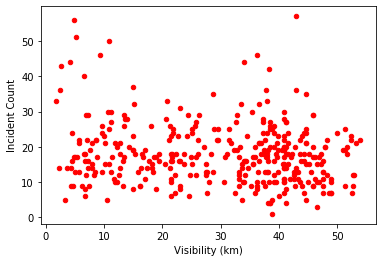

In [18]:
weather_merged_df.plot(kind='scatter',x='Visibility (km)',y='Count', color='red')
plt.ylabel('Incident Count')

In [19]:
# Create a new column called age_binned with five bins. Create a line or pointplot of blood_pressure vs age_binned for each dataset.
weather_merged_df['temp_binned'] = pd.cut(weather_merged_df['Temp (C)'],10)
weather_merged_df['visibility_binned'] = pd.cut(weather_merged_df['Visibility (km)'],10)

weather_merged_df

,Temp (C),Visibility (km),Count,temp_binned,visibility_binned
Date/Time,,,,,
2018-01-01,-16.683333,42.570833,12,"(-19.993, -14.752]","(38.325, 43.548]"
2018-01-02,-3.787500,40.891667,30,"(-4.272, 0.969]","(38.325, 43.548]"
2018-01-03,-2.391667,39.212500,26,"(-4.272, 0.969]","(38.325, 43.548]"
2018-01-04,-5.016667,40.891667,22,"(-9.512, -4.272]","(38.325, 43.548]"
2018-01-05,-0.345833,40.891667,20,"(-4.272, 0.969]","(38.325, 43.548]"
...,...,...,...,...,...
2018-12-27,-7.225000,12.650000,21,"(-9.512, -4.272]","(12.206, 17.43]"
2018-12-28,-4.633333,40.891667,10,"(-9.512, -4.272]","(38.325, 43.548]"
2018-12-29,1.600000,38.475000,4,"(0.969, 6.209]","(38.325, 43.548]"


Text(0, 0.5, 'Incident Count')

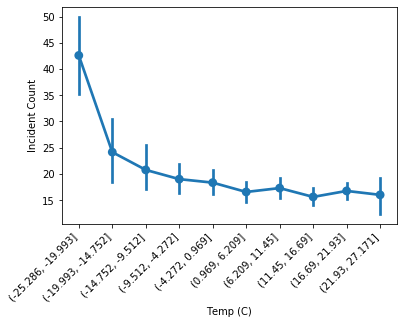

In [20]:
weather_temp_pointplot = sns.pointplot(x='temp_binned', y='Count', data=weather_merged_df)
weather_temp_pointplot.set_xticklabels(weather_temp_pointplot.get_xticklabels(),
                                       rotation=45,
                                       horizontalalignment='right')

plt.xlabel('Temp (C)')
plt.ylabel('Incident Count')

Text(0, 0.5, 'Incident Count')

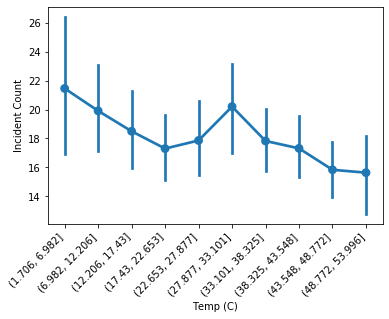

In [21]:
weather_visibility_pointplot = sns.pointplot(x='visibility_binned', y='Count', data=weather_merged_df)
weather_visibility_pointplot.set_xticklabels(weather_visibility_pointplot.get_xticklabels(),
                                             rotation=45,
                                             horizontalalignment='right')

plt.xlabel('Temp (C)')
plt.ylabel('Incident Count')

# Grid Analysis

In [22]:
# create dataframe containing only 2018 traffic data
ti_data_2018 = traffic_incident_df[traffic_incident_df['START_DT'].dt.year == 2018].copy()

# get coordinates of incidents to map to grid cell location
longitude_2018 = ti_data_2018.Longitude.tolist()
latitude_2018 = ti_data_2018.Latitude.tolist()

# map incident to grid cell
weather_data_cells = wf.get_cell_number(cells_df.values.tolist(), latitude_2018, longitude_2018)

#new_data_frame = data_2018.copy()
#new_data_frame['cell'] = weather_data_cells
ti_data_2018['cell'] = weather_data_cells

display(ti_data_2018)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,location,Count,id,cell
875,Southbound Deerfoot Trail and 16 Avenue NE,Multi-vehicle incident.,2018-05-07 18:30:02,2018-05-07 19:07:04,NE,-114.028193,51.065699,"(51.06569942197, -114.028192583328)",1,2018-05-07T17:30:0251.0656994219703-114.028192...,37
2169,36 Avenue and Burnsland Road SE,Two vehicle incident.,2018-05-25 14:53:33,2018-05-25 15:31:13,SE,-114.059276,51.021205,"(51.021204781033, -114.059276077804)",1,2018052514533351.0212047810334-114.059276077804,56
3262,Falconridge Boulevard at Castleridge Boulevard NE,Two vehicle incident.,2018-05-25 15:29:49,2018-05-25 16:27:18,NE,-113.958764,51.099956,"(51.099956277275, -113.958763979051)",1,2018052515294951.0999562772749-113.958763979051,38
4559,Southbound Deerfoot Trail and 16 Avenue NE,Multi-vehicle incident.,2018-05-07 18:30:02,2018-05-07 18:31:50,NE,-114.028183,51.065739,"(51.065739428335, -114.028183476698)",1,2018-05-07T17:30:0251.0657394283348-114.028183...,37
4695,Spruce Meadows Trail and Macleod Trail SE,Two vehicle incident.,2018-05-07 19:33:14,2018-05-07 19:44:52,SE,-114.061310,50.892629,"(50.892628633145, -114.06131023126)",1,2018-05-07T18:33:1450.8926286331446-114.061310...,86
...,...,...,...,...,...,...,...,...,...,...,...
17407,Westbound 16 Avenue approaching Deerfoot Trail NE,Two vehicle incident. Blocking the left lane.,2018-12-31 17:47:41,2018-12-31 17:49:08,NE,-114.020057,51.067053,"(51.067052792253, -114.020056658954)",1,2018123117474151.0670527922526-114.020056658954,37
17408,Southbound Crowchild Trail at Kensington Road NW,Two vehicle incident. Blocking multiple lanes,2018-12-31 17:59:28,2018-12-31 18:16:01,NW,-114.118501,51.052492,"(51.052492333505, -114.11850138363)",1,2018123117592851.0524923335053-114.11850138363,45
17409,52 Street and 5 Avenue SE,Multi-vehicle incident.,2018-12-31 18:42:53,2018-12-31 18:43:50,SE,-113.956571,51.049133,"(51.049133273898, -113.956570563768)",1,2018123118425351.049133273898-113.956570563768,48
17410,Eastbound Memorial Drive at 8 Street NW,Two vehicle incident.,2018-12-31 20:00:47,2018-12-31 20:02:03,NW,-114.079493,51.054765,"(51.05476543077, -114.079492649993)",1,2018123120004751.0547654307696-114.079492649993,46


In [23]:
# groups incidents by date and cell
daily_cell_incidents = ti_data_2018.groupby([pd.to_datetime(ti_data_2018.START_DT).dt.date,'cell']).agg({
    'Count': 'sum'
}).sort_index()

display(daily_cell_incidents)

Count
START_DT   cell       
2018-01-01 15        1
           24        1
           38        2
           46        4
           47        2
...                ...
2018-12-31 46        2
           48        2
           57        1
           67        1
           77        1

[4748 rows x 1 columns]

In [24]:
#display(ti_data_2018)
testing2 = ti_data_2018.copy()
ti_data_2018['START_DT'] = pd.to_datetime(ti_data_2018.START_DT.dt.date)
ti_data_2018['MODIFIED_DT'] = pd.to_datetime(ti_data_2018.MODIFIED_DT.dt.date)
ti_data_2018.sort_values(by=['START_DT'], inplace=True)

date_list = ti_data_2018['START_DT']

#for d in date_list:
    #print(daily_weather_data.loc[[d]]['Temp (C)'][0])
    
# clean dataframe to only display columns to be analyzed
weather_grid_data_merged = pd.merge(ti_data_2018, weather_merged_df, left_on='START_DT', right_index=True)
weather_grid_data_merged.drop(weather_grid_data_merged.columns.difference(['START_DT',
                                                                           'Count_x',
                                                                           'cell',
                                                                           'Temp (C)',
                                                                           'Visibility (km)',
                                                                           'temp_binned',
                                                                           'visibility_binned']), 1, inplace=True)

pd.set_option('display.max_rows',10)
weather_grid_data_merged.reset_index(drop=True, inplace=True)
weather_grid_data_merged.rename(columns={'START_DT':'Date','Count_x':'Count'}, inplace=True)
weather_grid_data_merged = weather_grid_data_merged[weather_grid_data_merged.cell != -1]

weather_grid_data_merged

,Date,Count,cell,Temp (C),Visibility (km),temp_binned,visibility_binned
0,2018-01-01,1,15,-16.683333,42.570833,"(-19.993, -14.752]","(38.325, 43.548]"
1,2018-01-01,1,46,-16.683333,42.570833,"(-19.993, -14.752]","(38.325, 43.548]"
2,2018-01-01,1,46,-16.683333,42.570833,"(-19.993, -14.752]","(38.325, 43.548]"
3,2018-01-01,1,87,-16.683333,42.570833,"(-19.993, -14.752]","(38.325, 43.548]"
4,2018-01-01,1,24,-16.683333,42.570833,"(-19.993, -14.752]","(38.325, 43.548]"
...,...,...,...,...,...,...,...
6562,2018-12-31,1,77,-11.916667,38.145833,"(-14.752, -9.512]","(33.101, 38.325]"
6563,2018-12-31,1,48,-11.916667,38.145833,"(-14.752, -9.512]","(33.101, 38.325]"
6564,2018-12-31,1,46,-11.916667,38.145833,"(-14.752, -9.512]","(33.101, 38.325]"
6565,2018-12-31,1,38,-11.916667,38.145833,"(-14.752, -9.512]","(33.101, 38.325]"


# Temperature Grid Analysis

In [25]:
# get the TOTAL number of incidents that occur in a grid at a specific temperature range
groupby_temp_binned = weather_grid_data_merged.groupby(['temp_binned','cell']).agg({'Count': 'sum'})

groupby_temp_binned = groupby_temp_binned[groupby_temp_binned['Count'].notna()]
groupby_temp_binned['Count'] = groupby_temp_binned.Count.astype(int)

groupby_temp_binned

Count
temp_binned        cell       
(-25.286, -19.993] 13        1
                   14        3
                   15        4
                   16        2
                   17        1
...                        ...
(21.93, 27.171]    68        1
                   76        3
                   77        2
                   78        1
                   88        1

[559 rows x 1 columns]

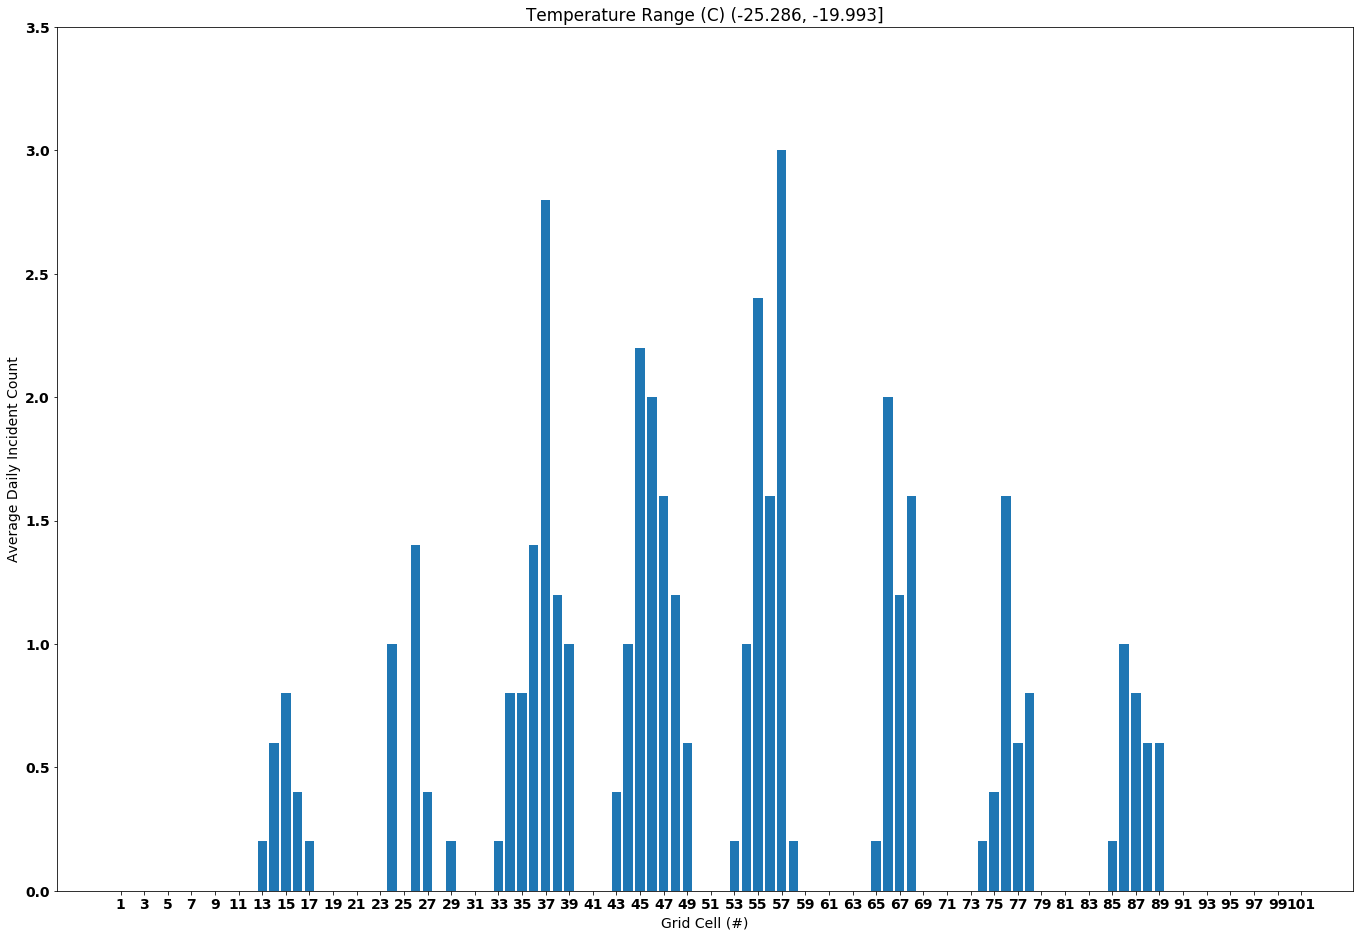

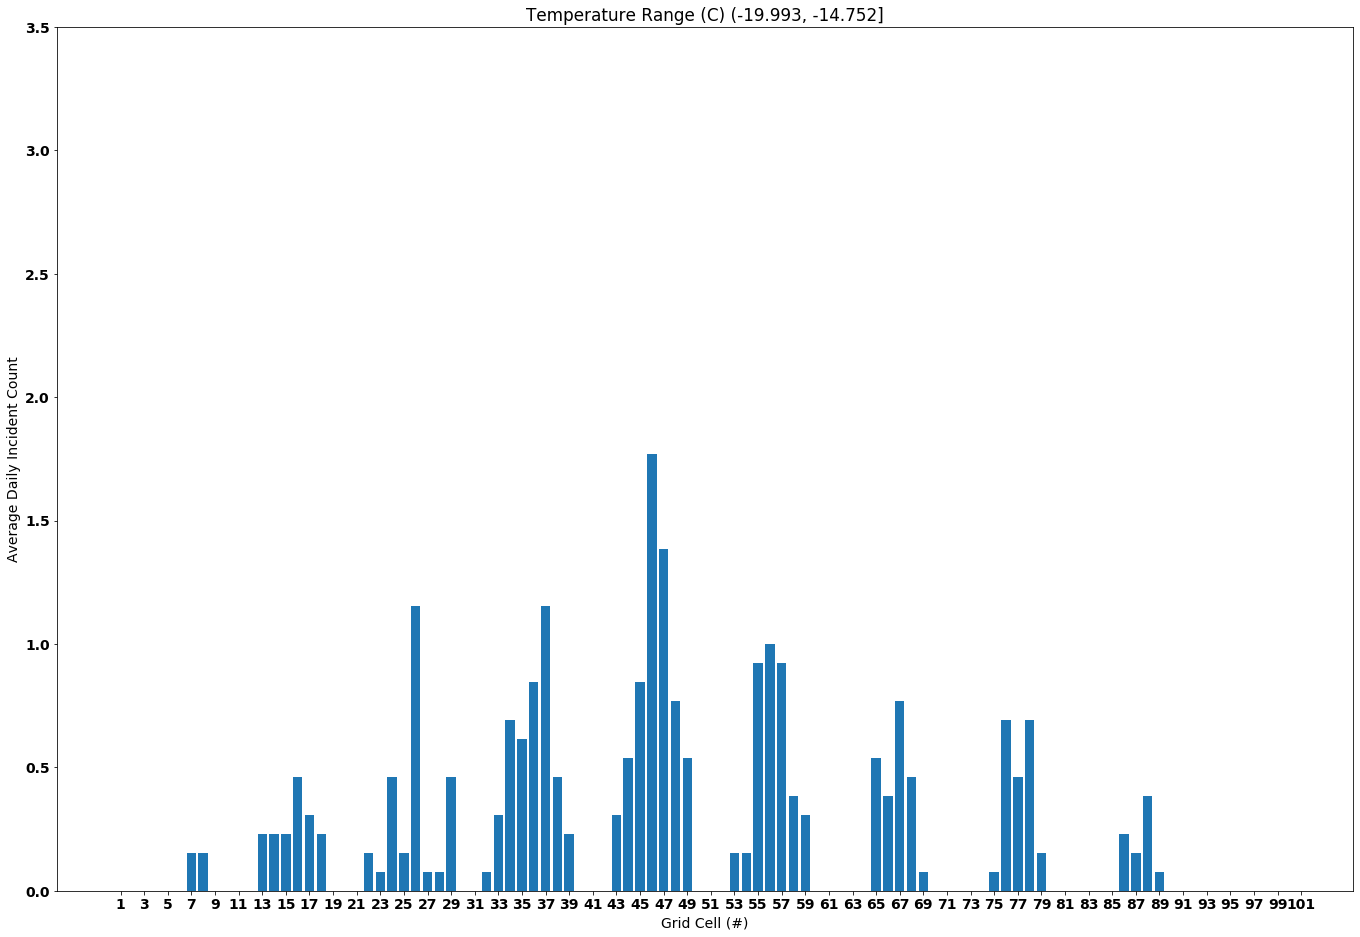

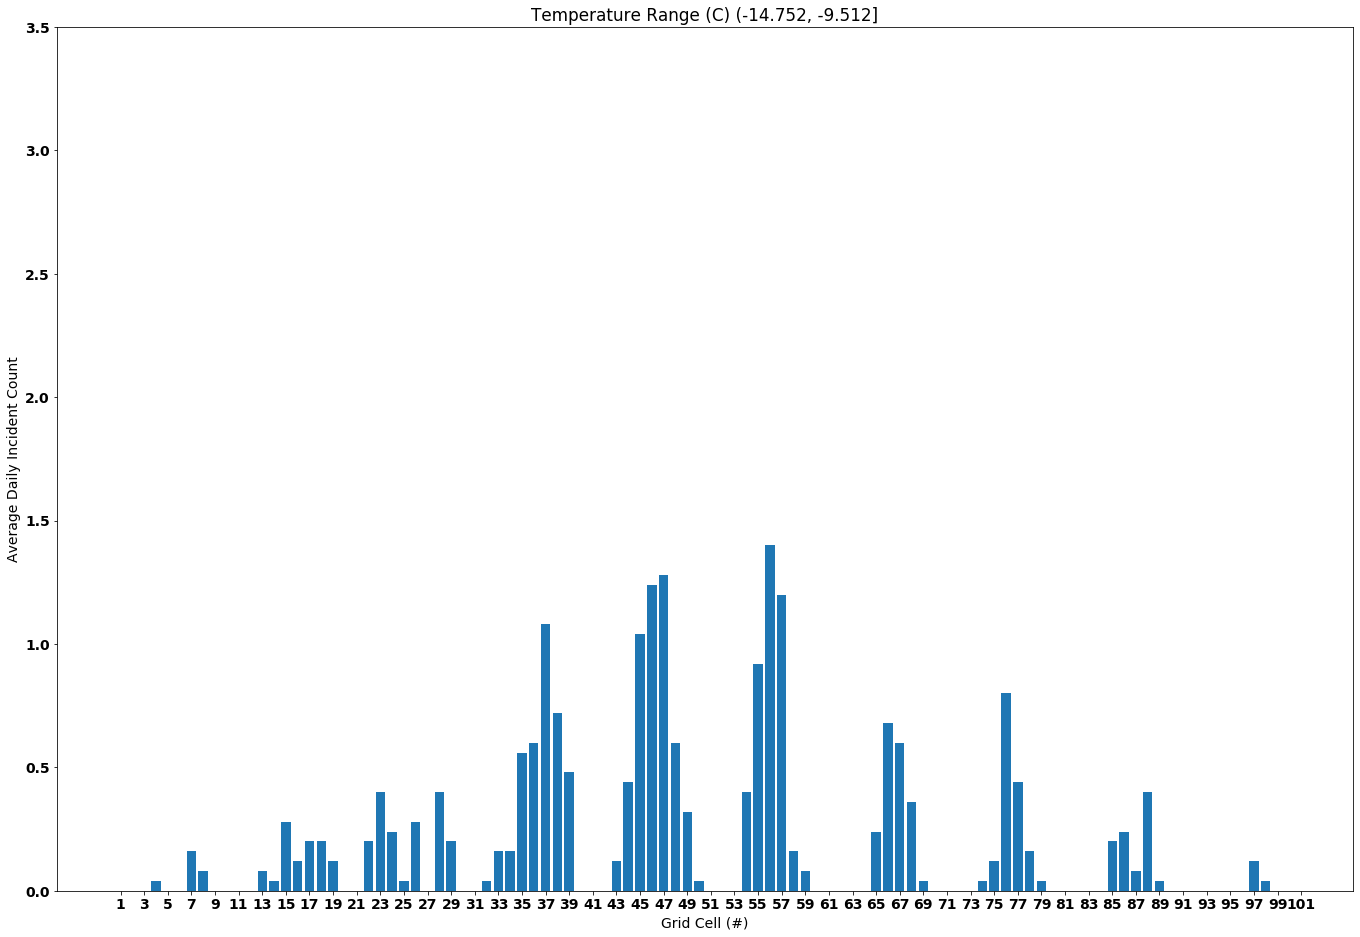

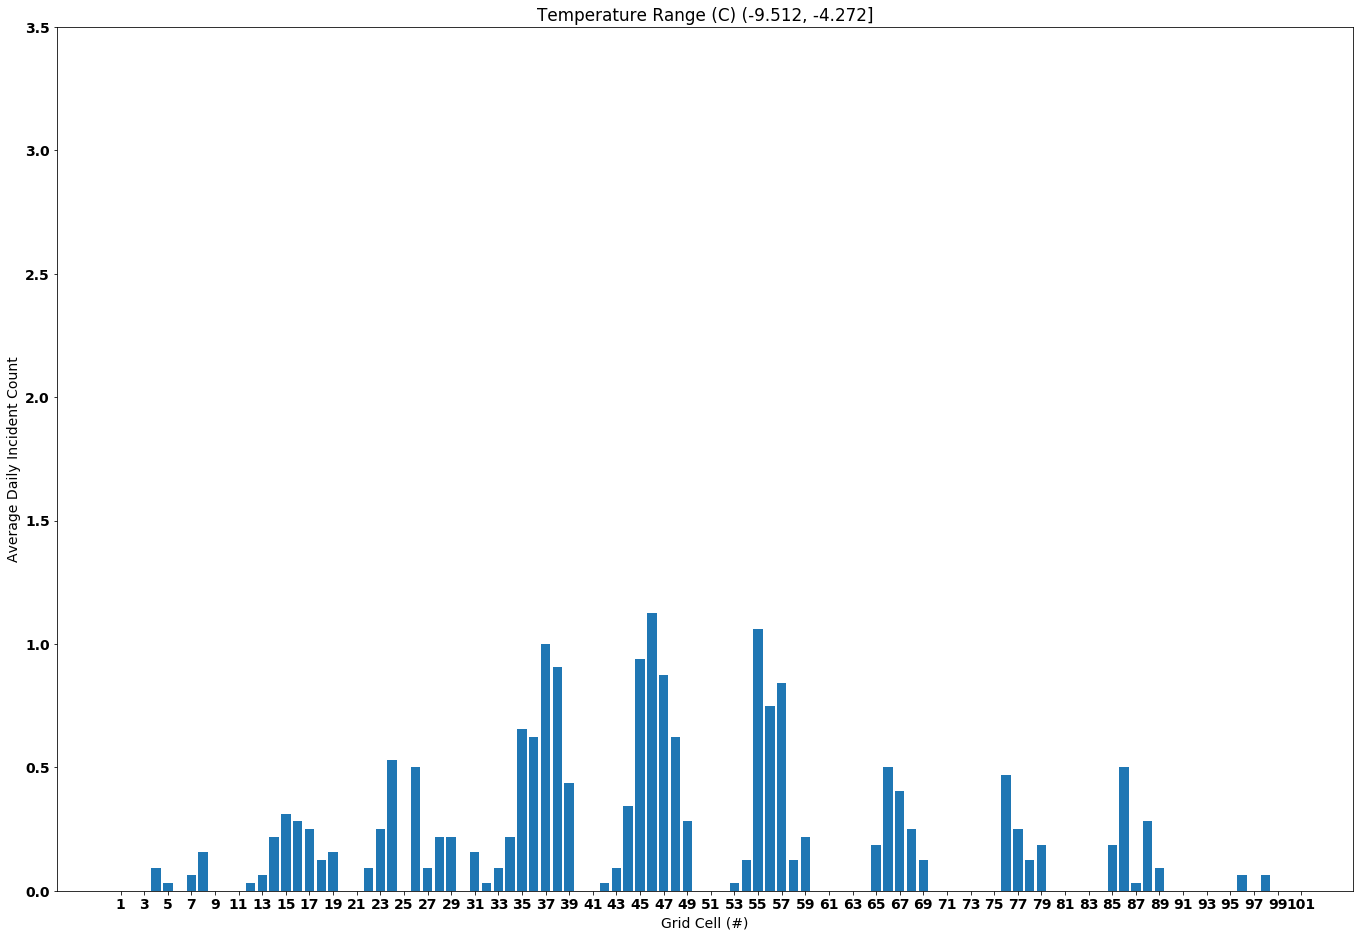

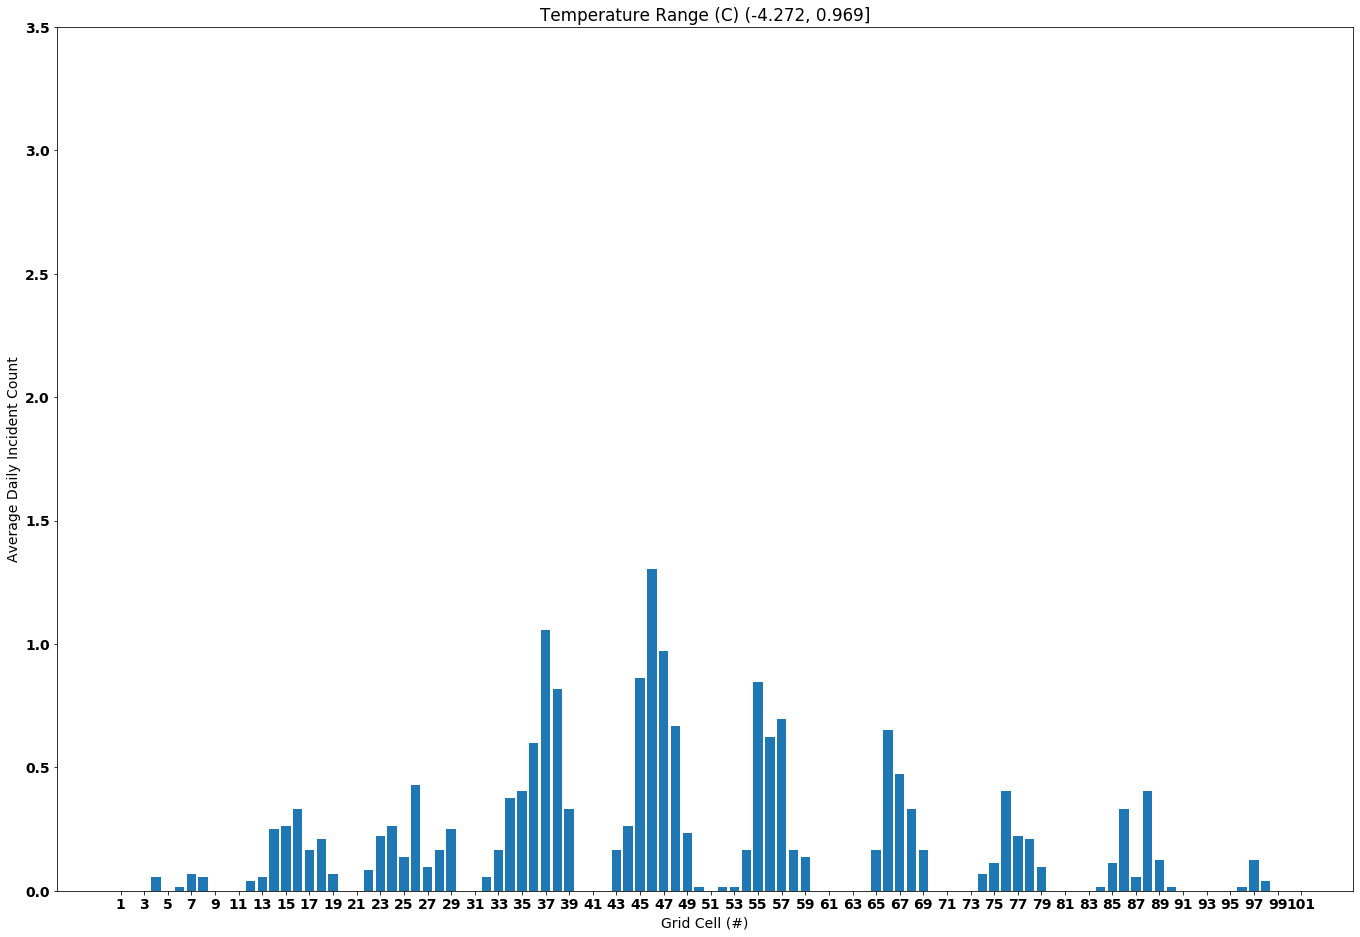

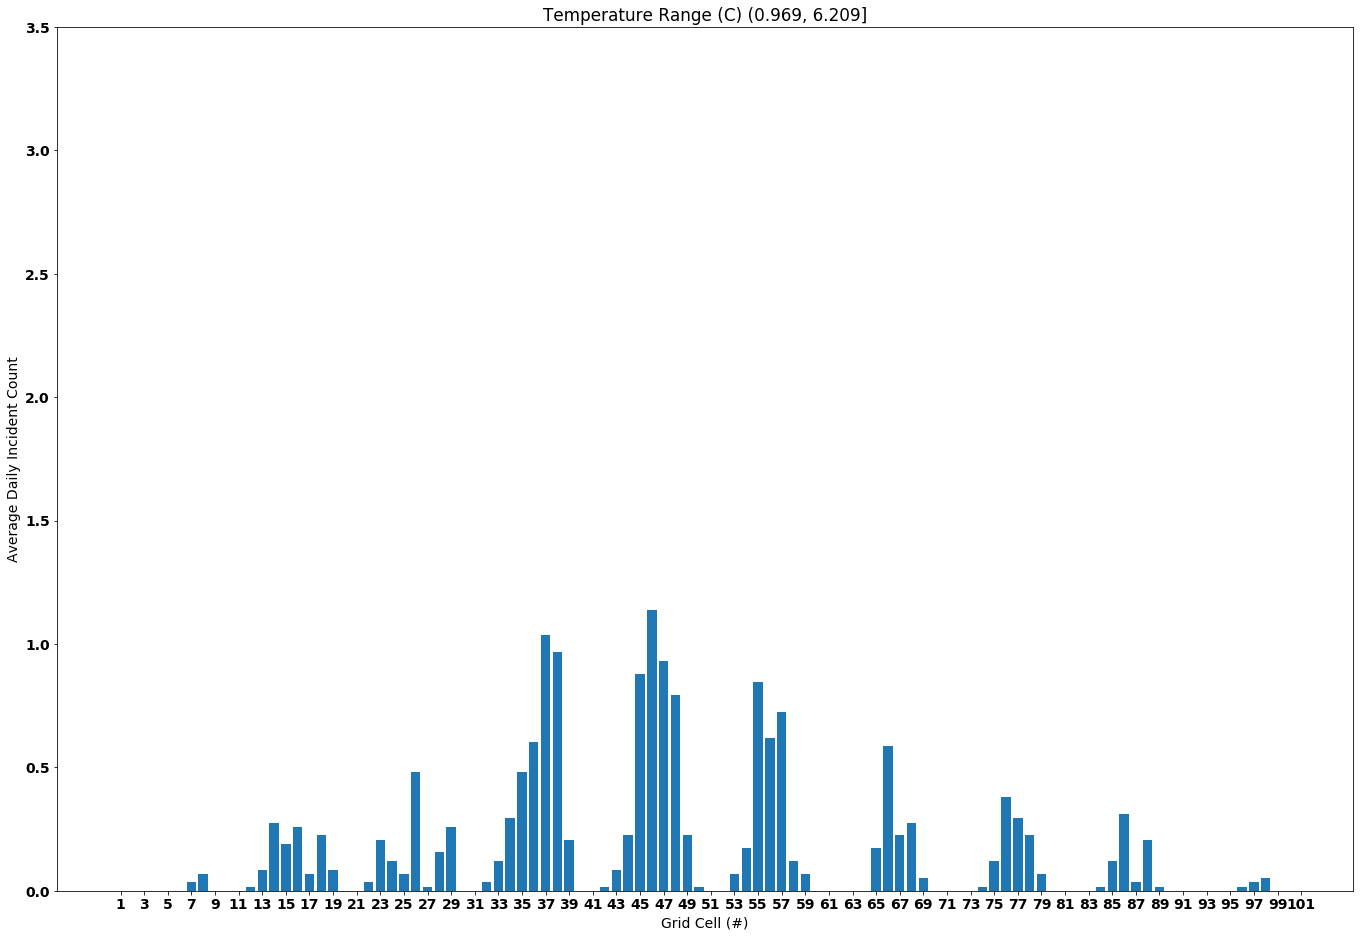

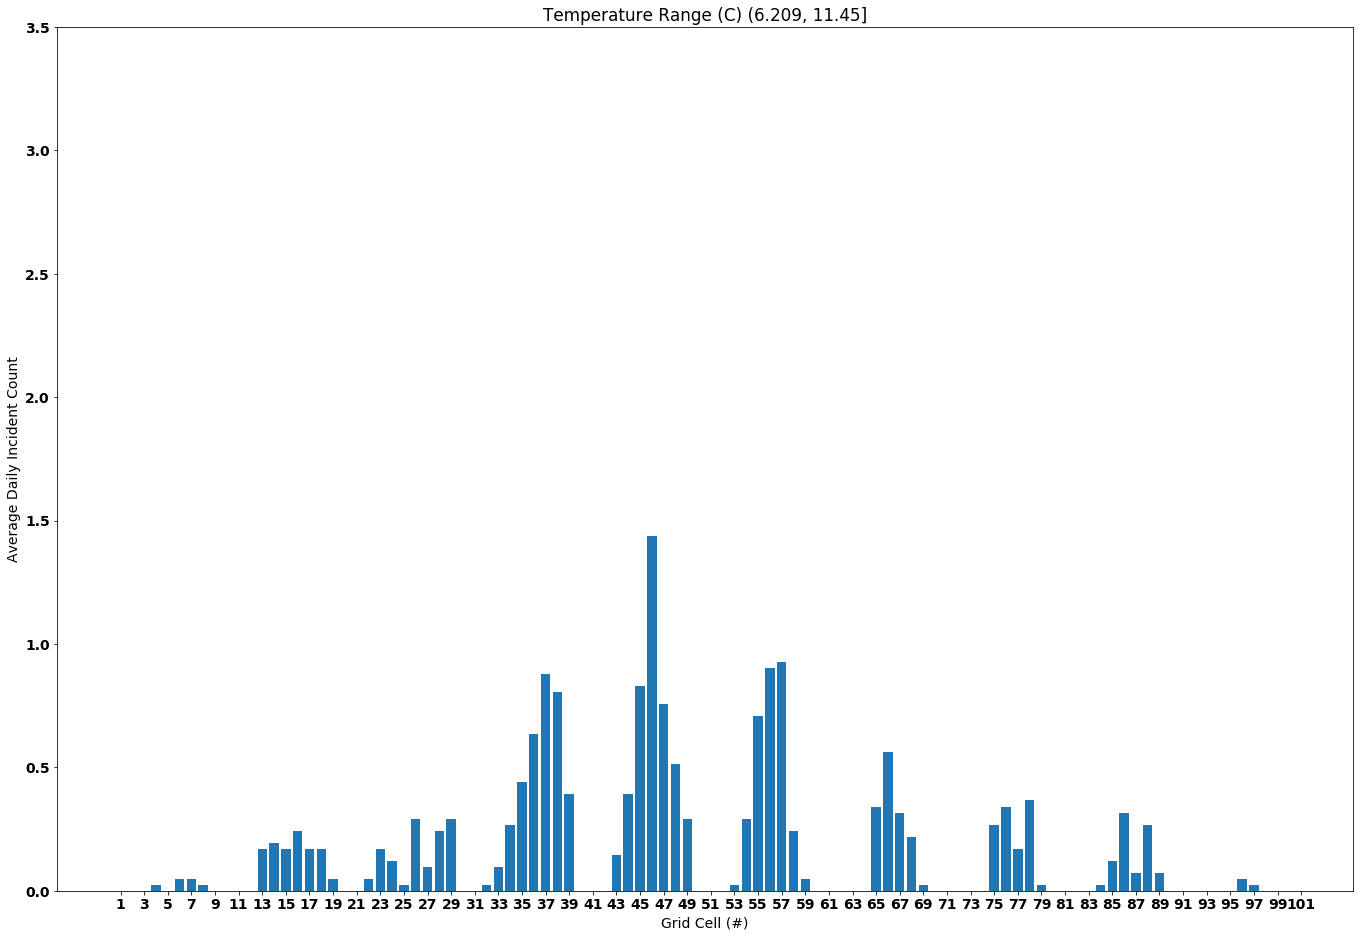

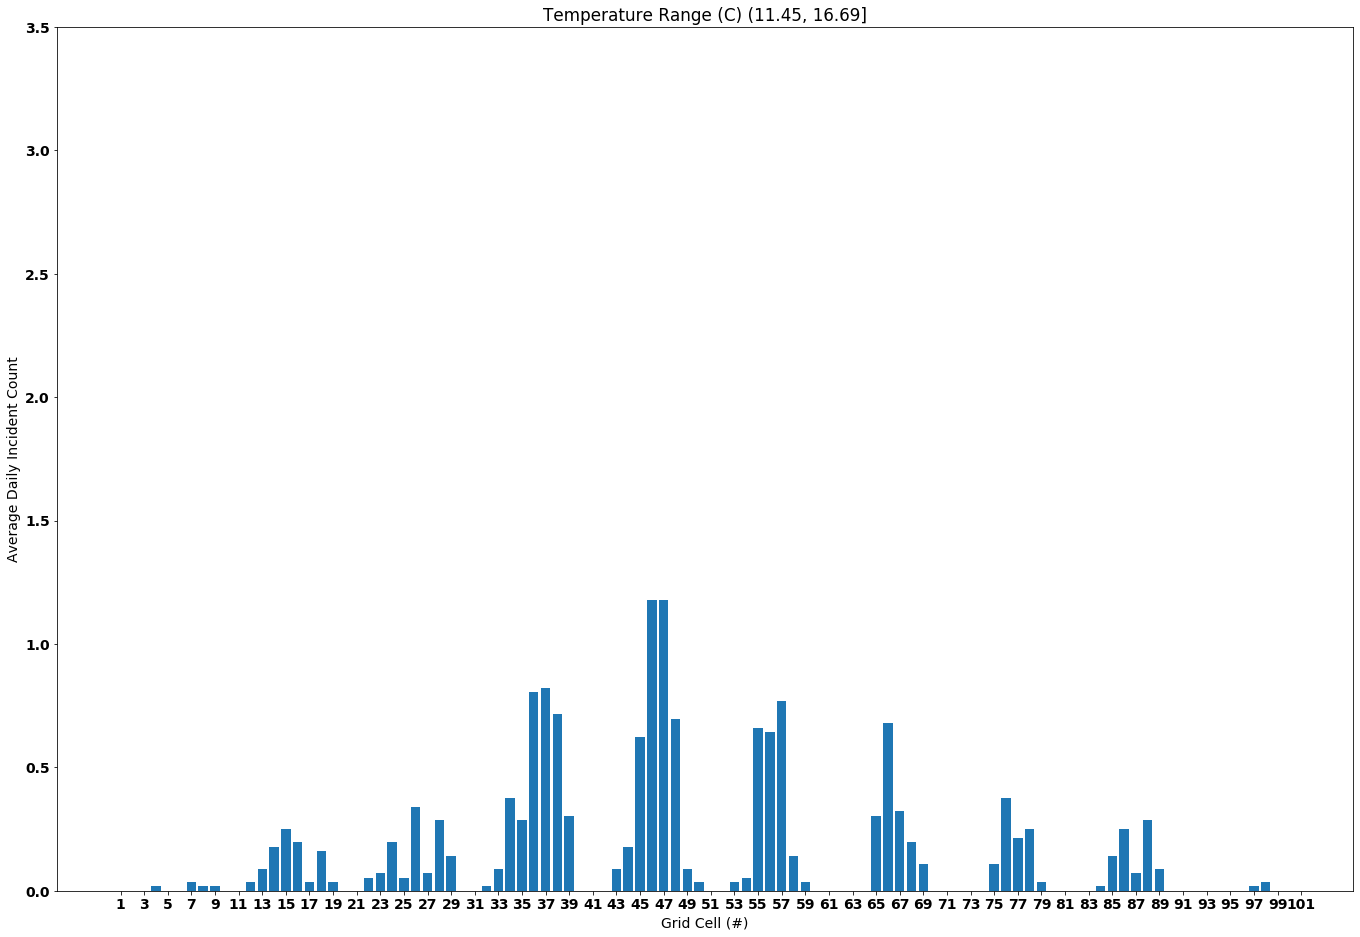

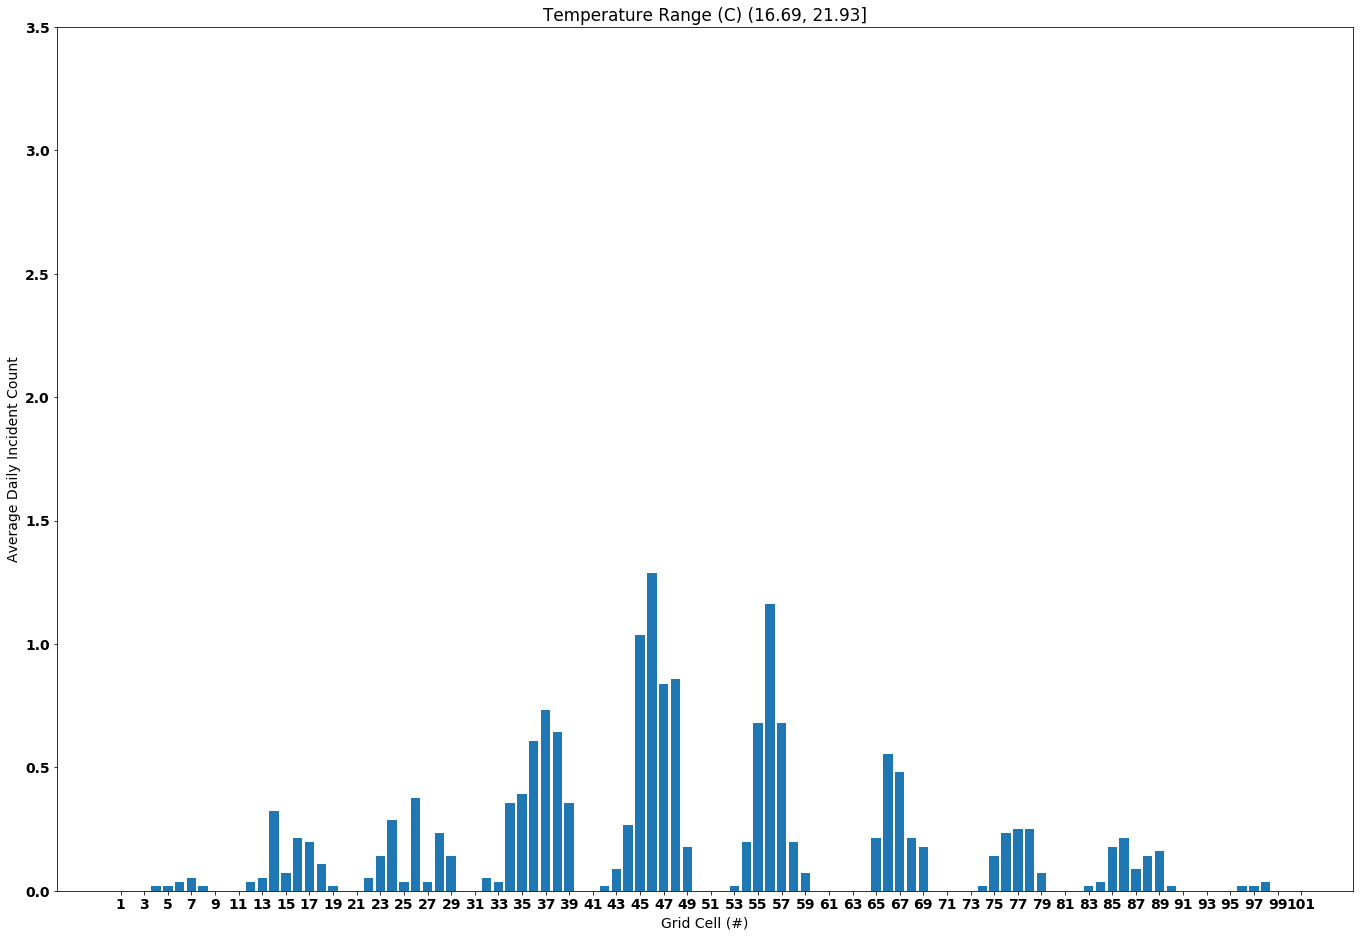

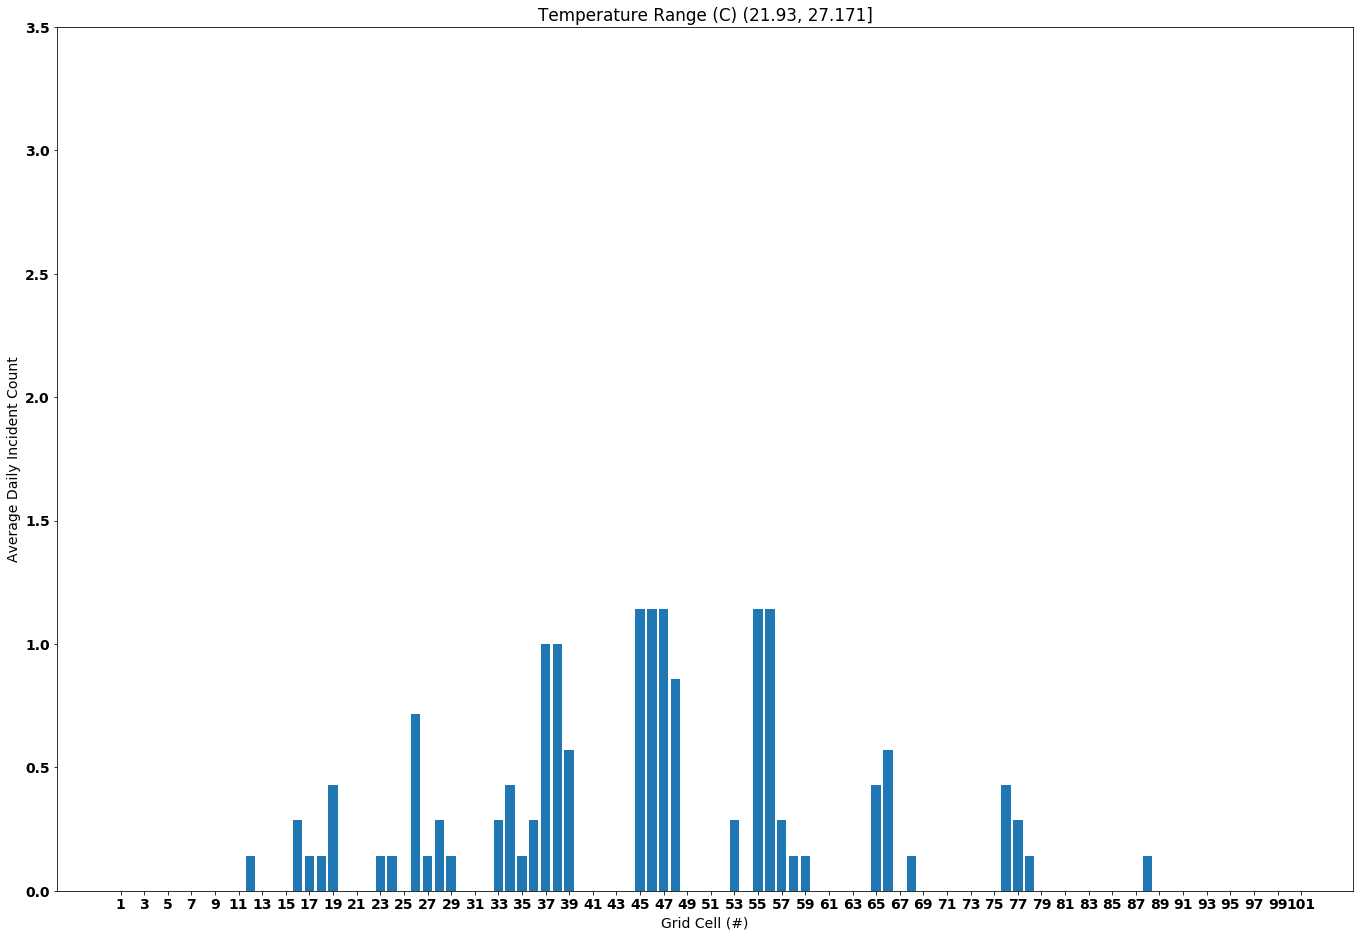

In [26]:
# get temperature bins sorted in ascending order
temp_bins_df = weather_merged_df.groupby('temp_binned').size().to_frame()
temp_bins = temp_bins_df.index.tolist()
occurrences = weather_merged_df.groupby('temp_binned').size().tolist()

# map bin to temperature occurrence value
bin_occurrences_dict = {}
for i in range(len(temp_bins)):
    bin_occurrences_dict[temp_bins[i]] = occurrences[i]
    

# create bar graph of cell vs incident count for each bin (10 graphs) of the AVERAGE incident at each grid
for bin in temp_bins:
    cell_incidents = [0]*100
    cell_number = [0]*100
    
    for i in range(100):
        result_df = groupby_temp_binned.loc[(groupby_temp_binned.index.get_level_values('temp_binned') == bin) & 
                                        (groupby_temp_binned.index.get_level_values('cell') == i+1)]
                                         
        cell_incidents[i] = result_df.Count.sum() / bin_occurrences_dict.get(bin)
        cell_number[i] = i+1
    
    font = {'family' : 'DejaVu Sans','weight' : 'bold', 'size' : 14}
    plt.rc('font',**font)
    fig = plt.figure()
    ax = fig.add_axes([0,0,3,3])
    ax.bar(cell_number,cell_incidents)
    title = 'Temperature Range (C) ' + str(bin)
    plt.title(title)
    plt.xlabel('Grid Cell (#)')
    plt.ylabel('Average Daily Incident Count')
    plt.xticks(np.arange(1,102,2))
    plt.ylim((0,3.5))

# Visibility Grid Analysis

In [27]:
# get the TOTAL number of incidents that occur in a grid at a specific visibility range
groupby_vis_binned = weather_grid_data_merged.groupby(['visibility_binned','cell']).agg({'Count': 'sum'})

groupby_vis_binned = groupby_vis_binned[groupby_vis_binned['Count'].notna()]
groupby_vis_binned['Count'] = groupby_vis_binned.Count.astype(int)

groupby_vis_binned

Count
visibility_binned cell       
(1.706, 6.982]    7         6
                  8         1
                  12        1
                  13        8
                  14       17
...                       ...
(48.772, 53.996]  85        1
                  86        3
                  87        1
                  88        7
                  89        2

[578 rows x 1 columns]

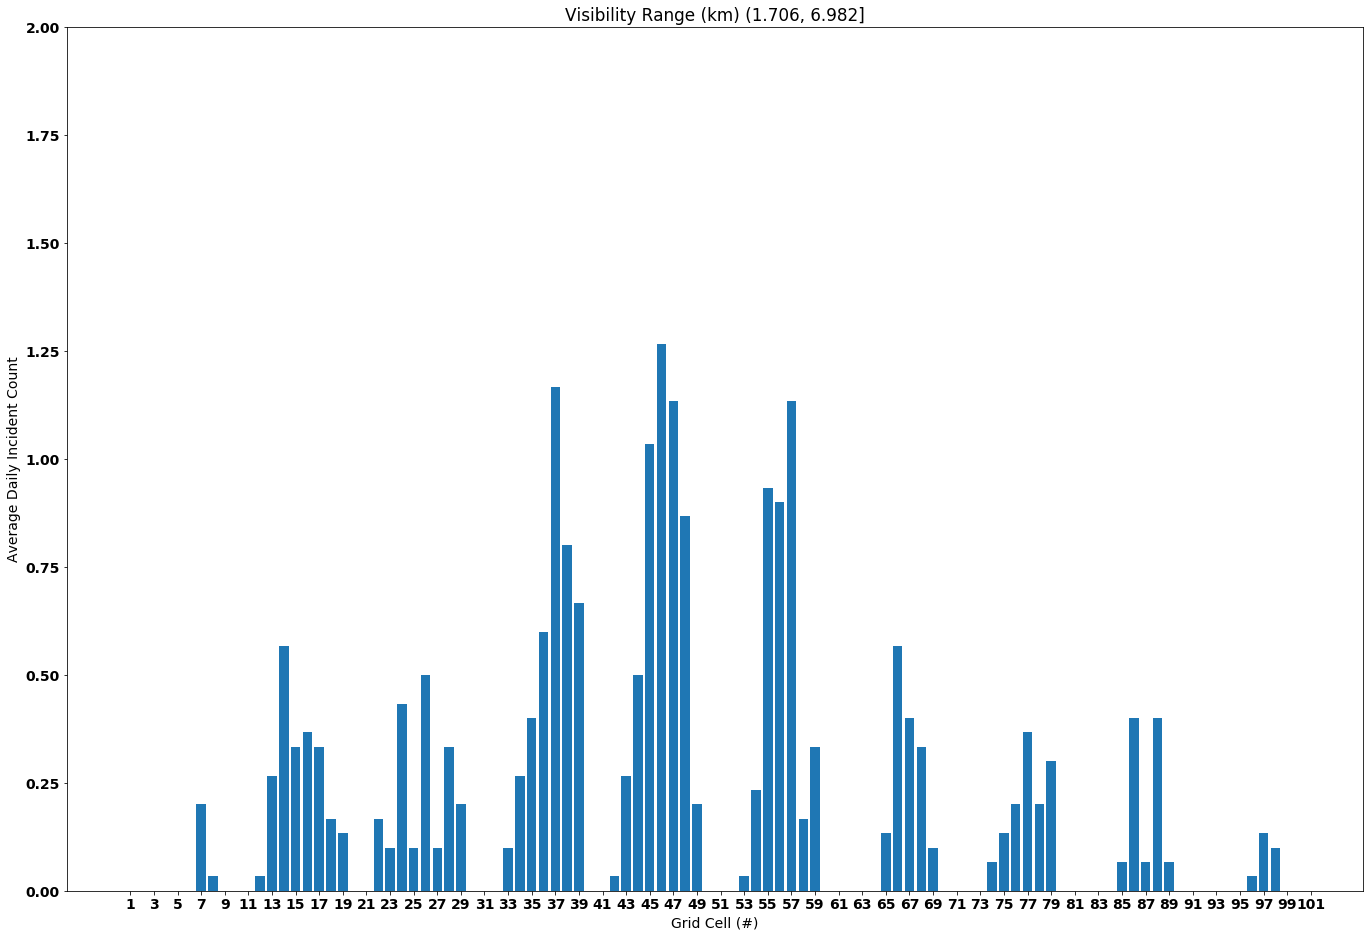

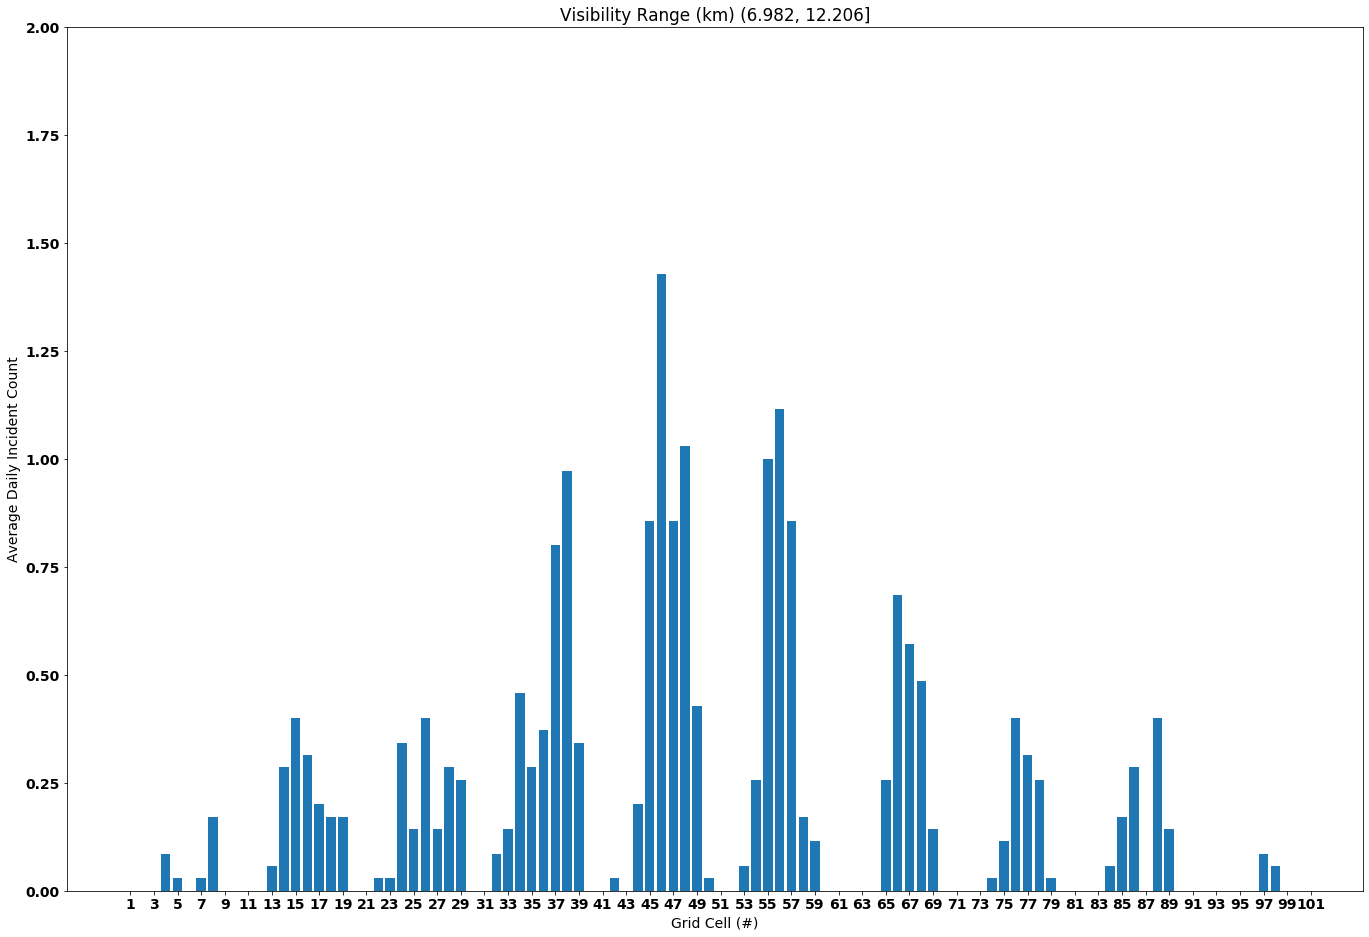

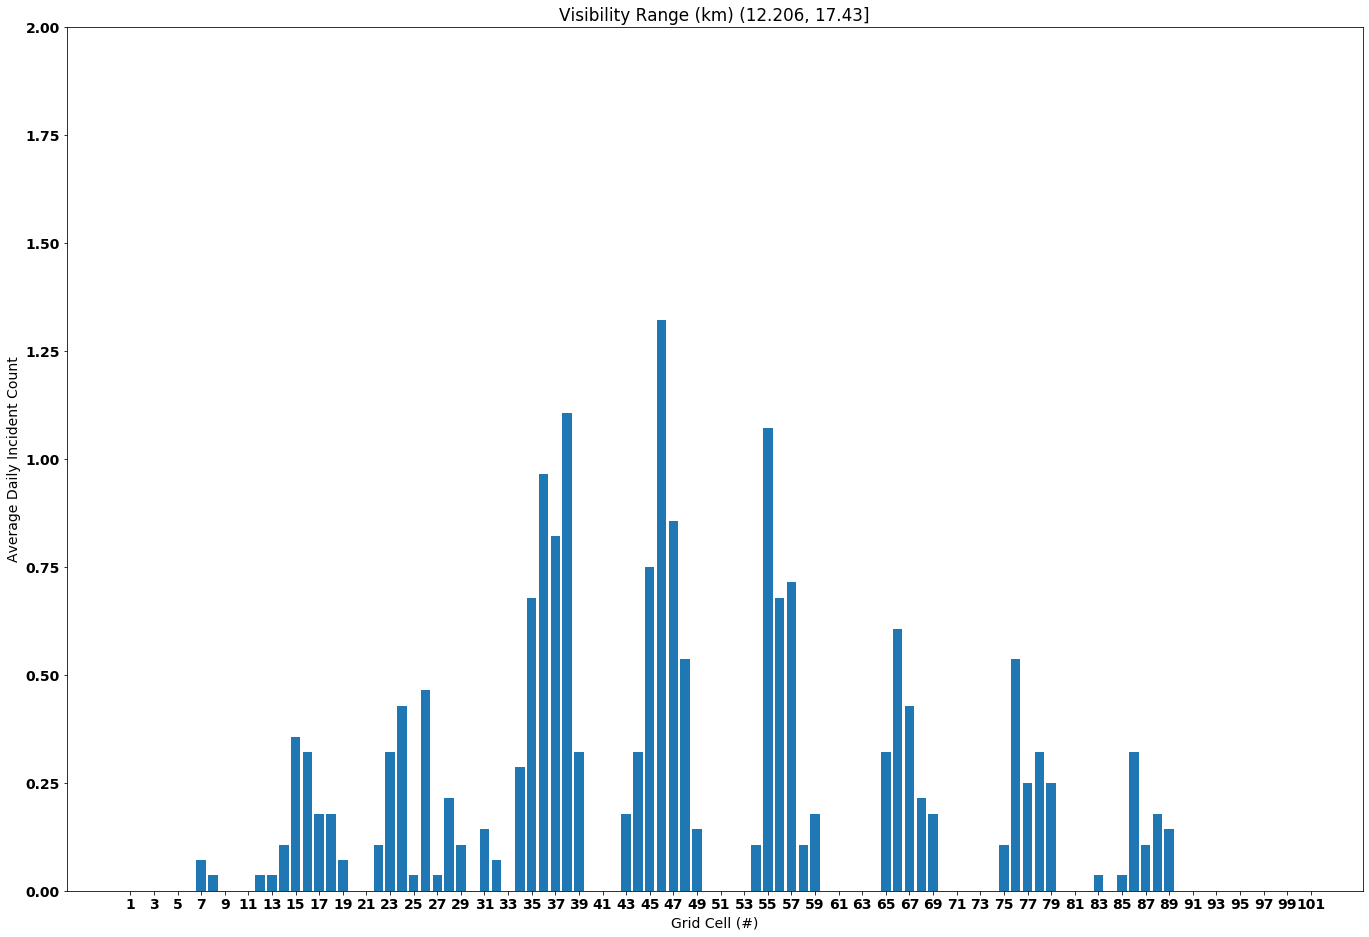

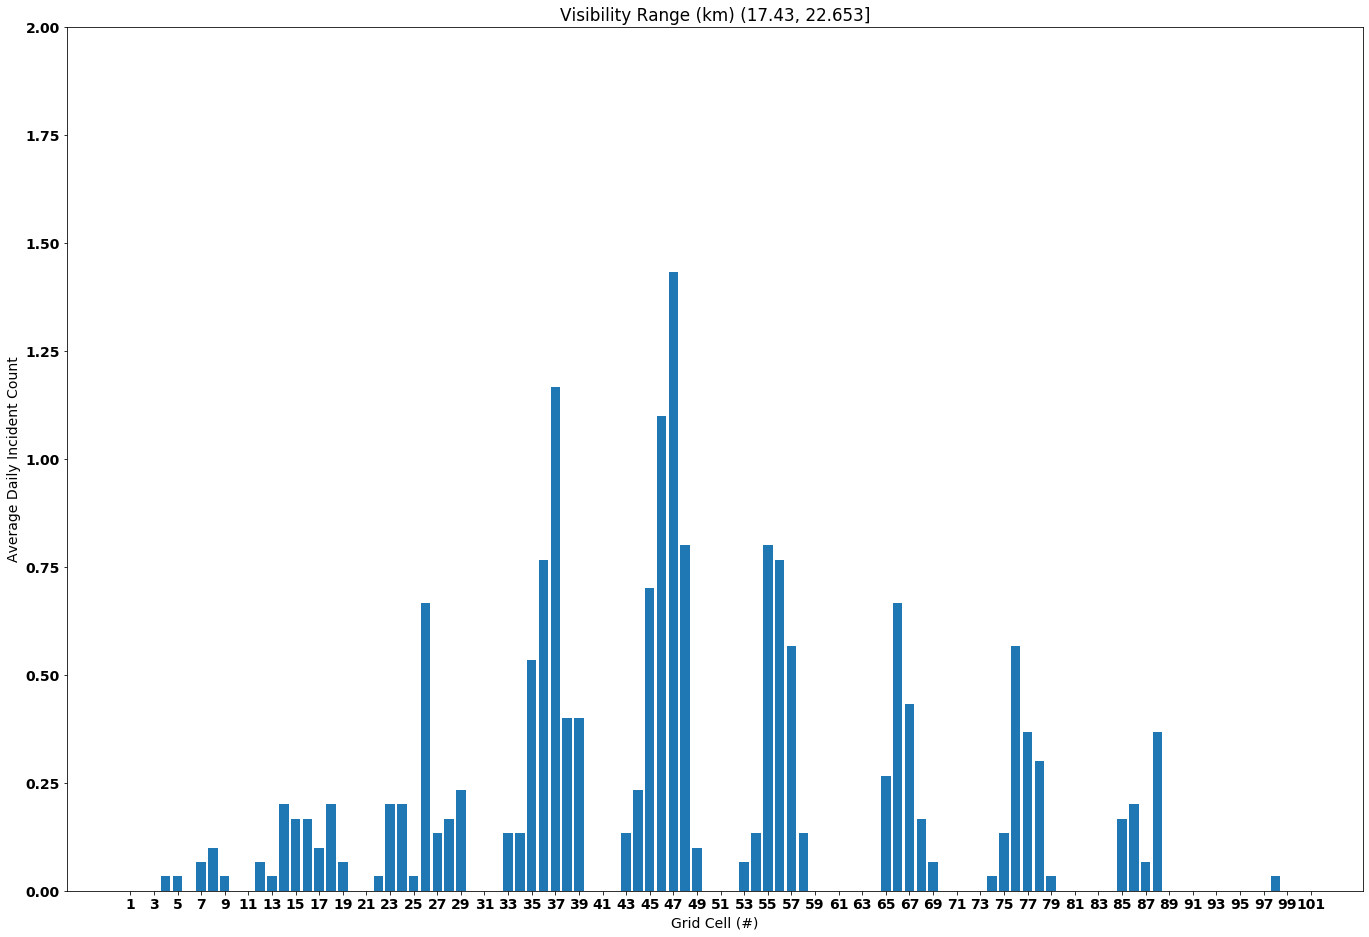

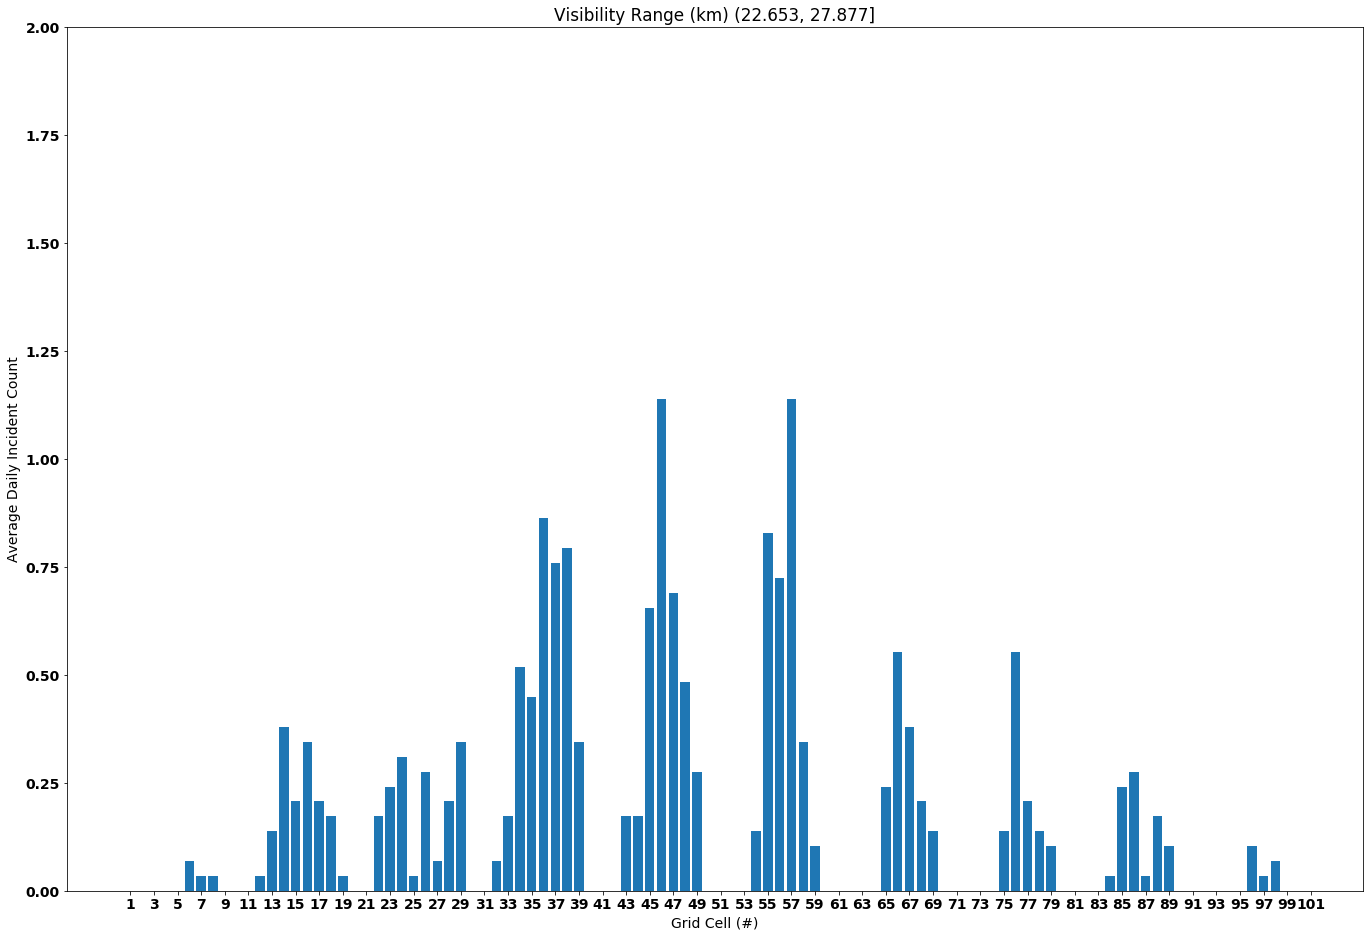

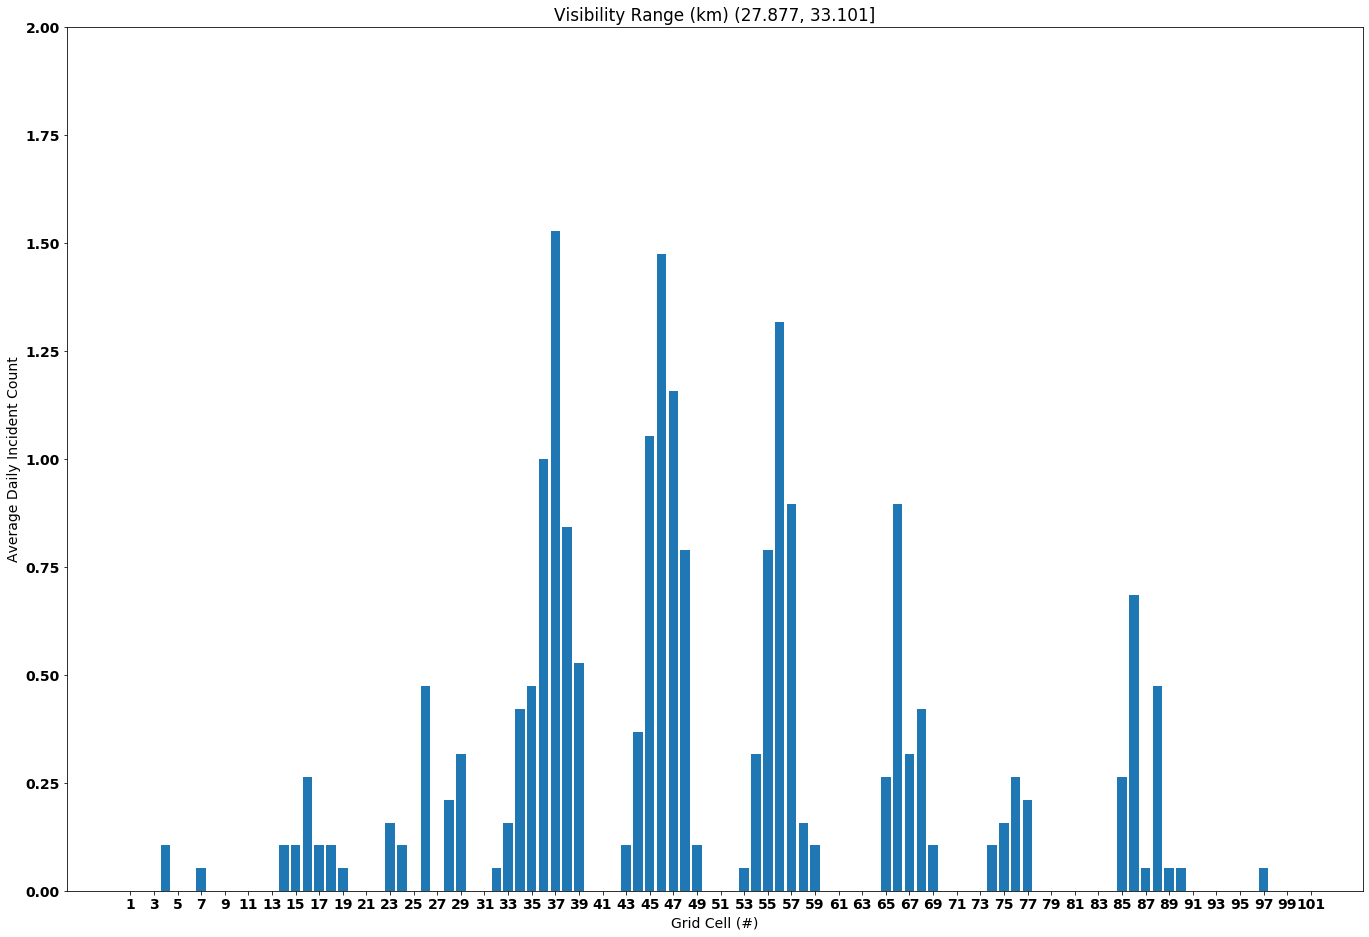

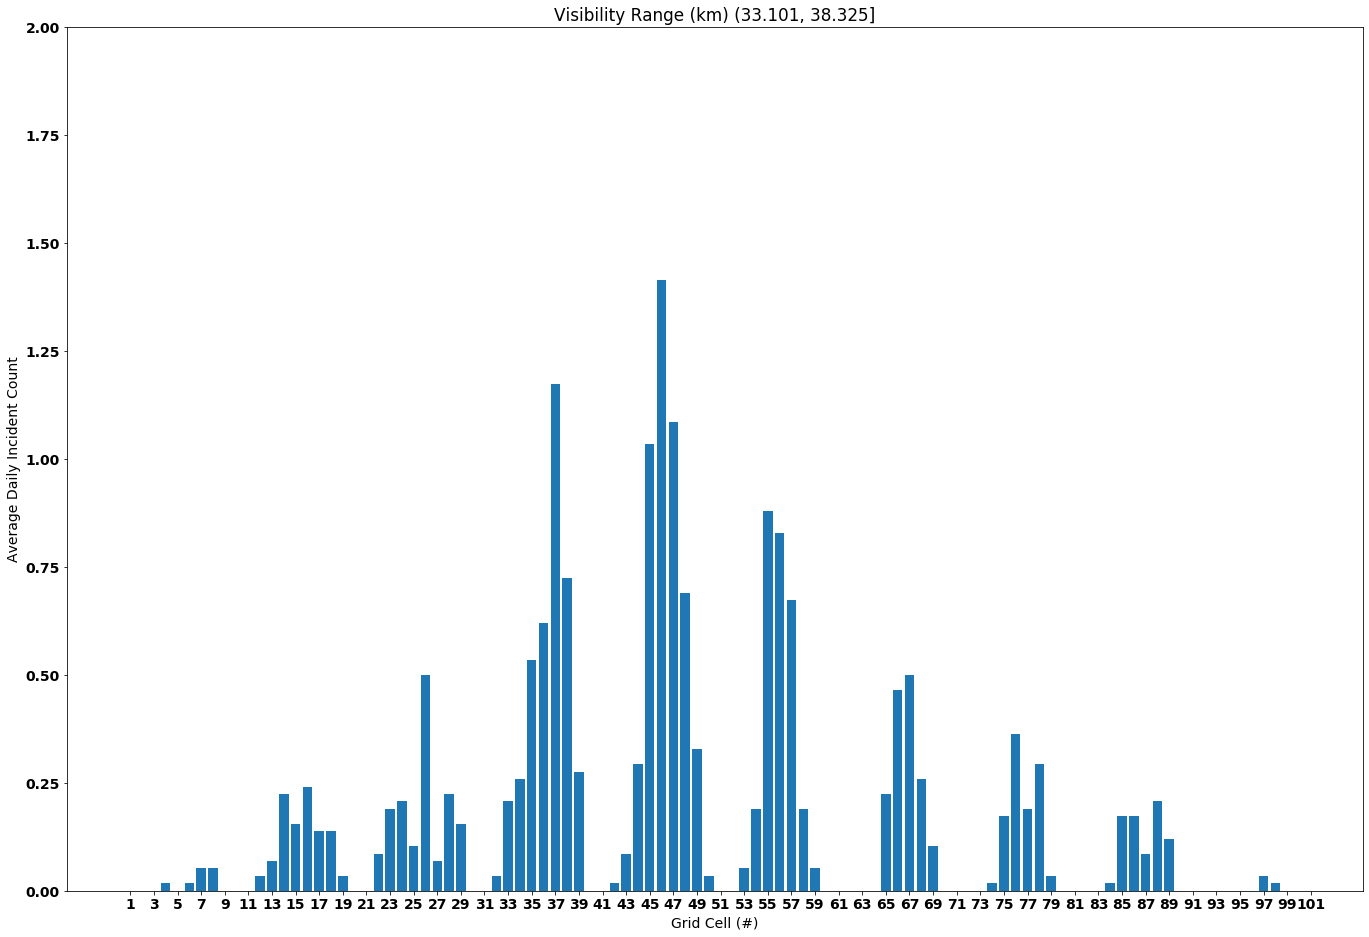

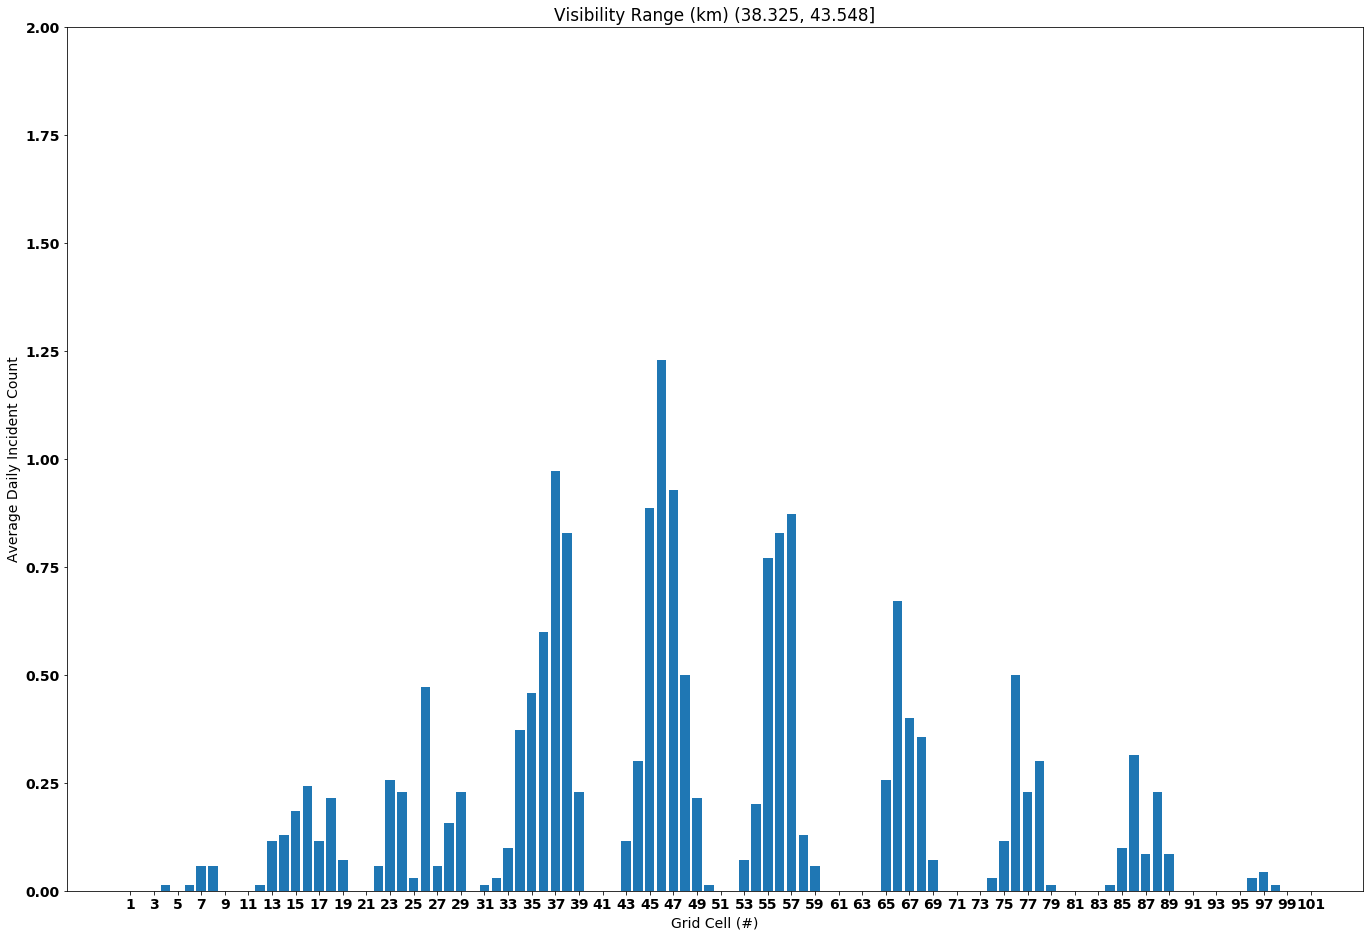

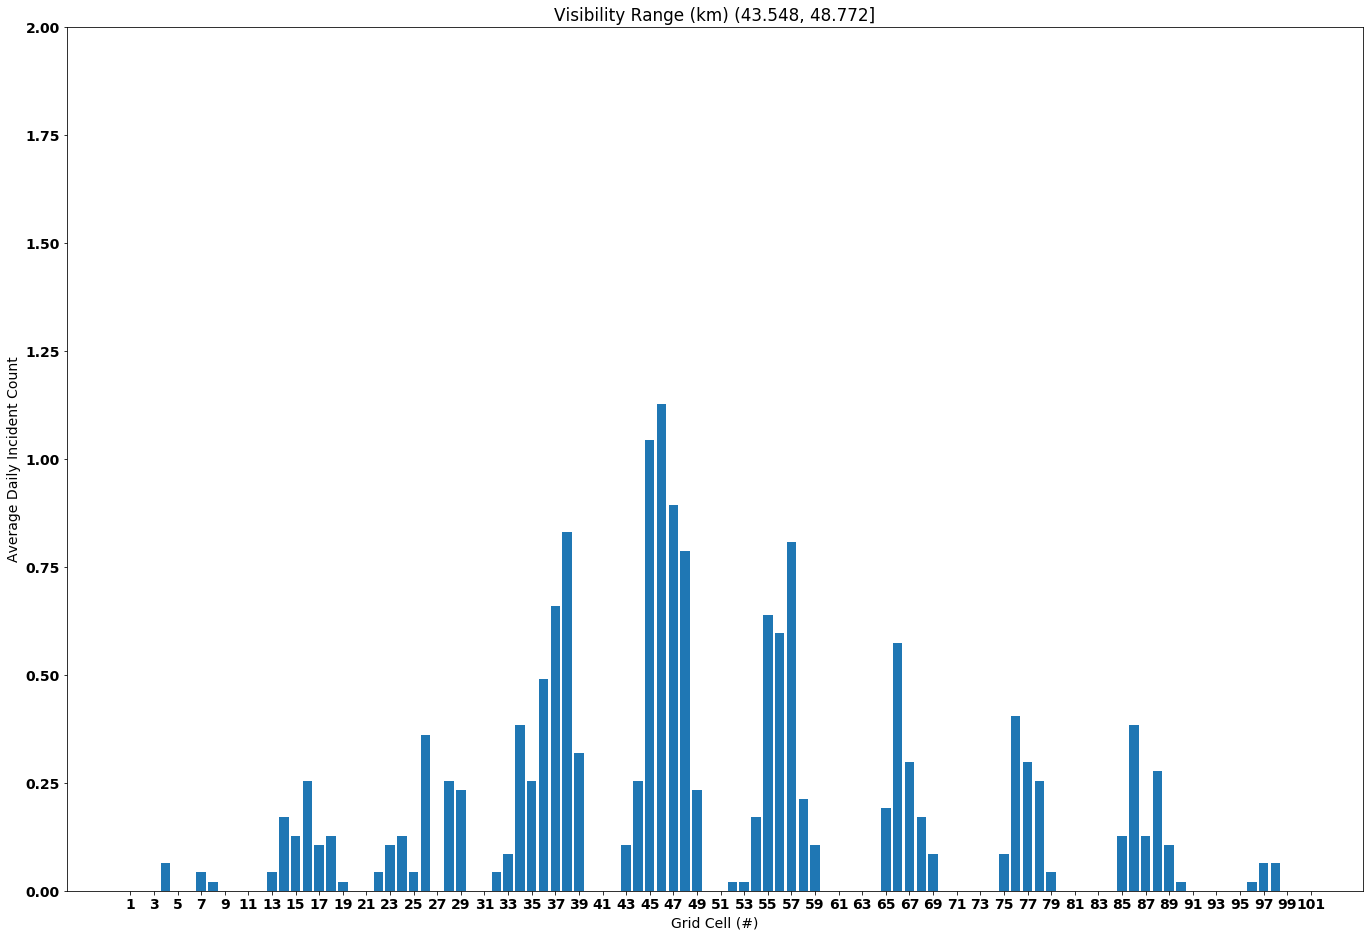

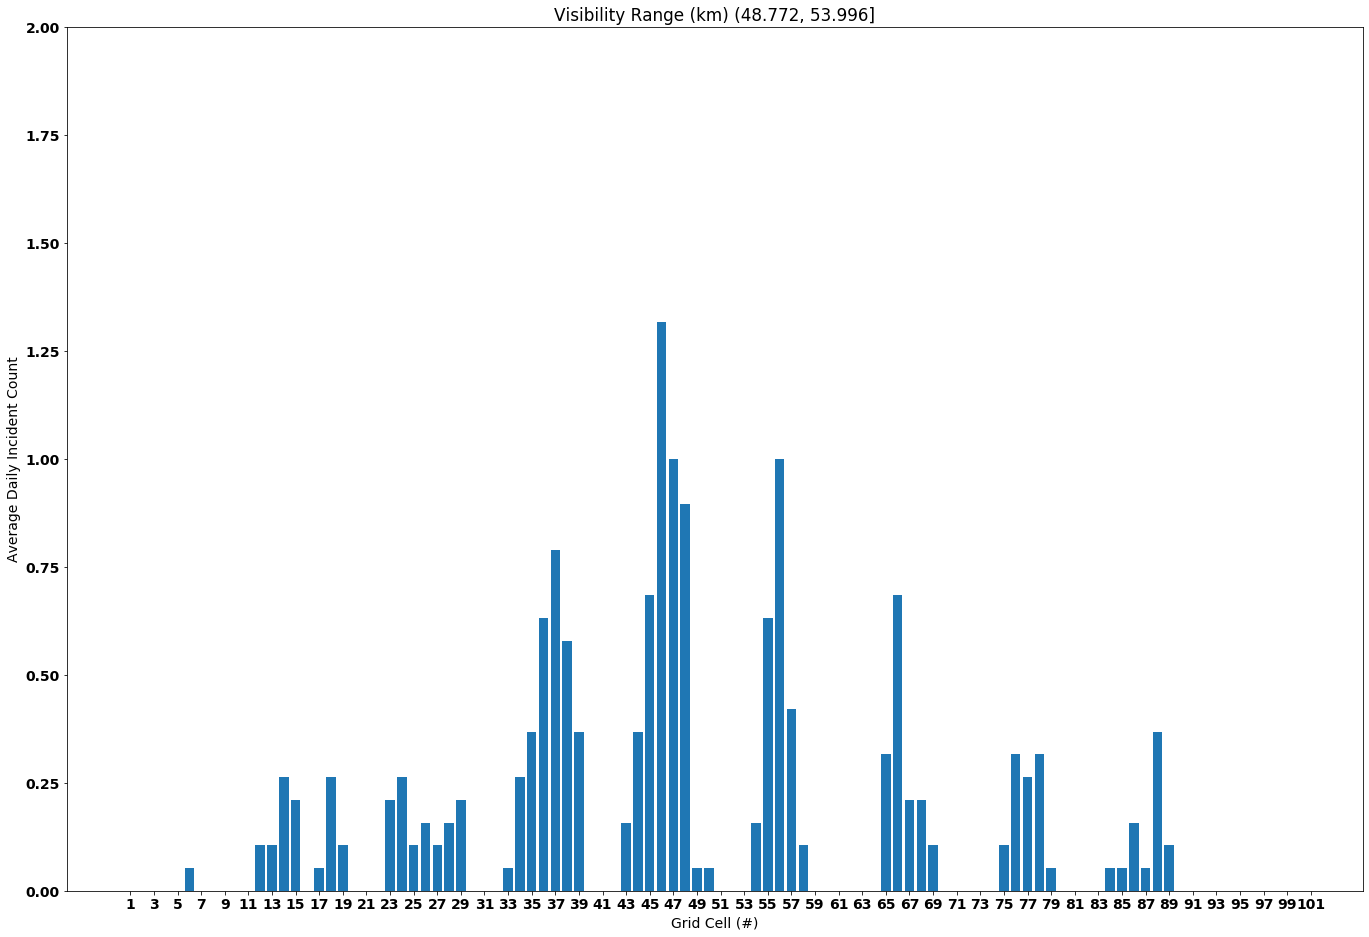

In [28]:
# get visibility bins sorted in ascending order
vis_bins_df = weather_merged_df.groupby('visibility_binned').size().to_frame()
vis_bins = vis_bins_df.index.tolist()
occurrences = weather_merged_df.groupby('visibility_binned').size().tolist()

# map bin to visibility occurrence value
bin_occurrences_dict = {}
for i in range(len(vis_bins)):
    bin_occurrences_dict[vis_bins[i]] = occurrences[i]
    

# create bar graph of cell vs incident count for each bin (10 graphs) of the AVERAGE incident at each grid
for bin in vis_bins:
    cell_incidents = [0]*100
    cell_number = [0]*100
    
    for i in range(100):
        result_df = groupby_vis_binned.loc[(groupby_vis_binned.index.get_level_values('visibility_binned') == bin) & 
                                        (groupby_vis_binned.index.get_level_values('cell') == i+1)]
                                         
        cell_incidents[i] = result_df.Count.sum() / bin_occurrences_dict.get(bin)
        cell_number[i] = i+1
    
    font = {'family' : 'DejaVu Sans','weight' : 'bold', 'size' : 14}
    plt.rc('font',**font)
    fig = plt.figure()
    ax = fig.add_axes([0,0,3,3])
    ax.bar(cell_number,cell_incidents)
    title = 'Visibility Range (km) ' + str(bin)
    plt.title(title)
    plt.xlabel('Grid Cell (#)')
    plt.ylabel('Average Daily Incident Count')
    plt.xticks(np.arange(1,102,2))
    plt.ylim((0,2))